#**FLEAD: Offline Simulation for Binary Anomaly Detection**

This notebook provides an offline simulation of the FLEAD project's core machine learning pipeline, specifically configured for **Binary Anomaly Detection (Normal vs. Anomaly)**. It uses the `Edge-IIoTset` dataset to demonstrate the end-to-end process of training a federated Long Short-Term Memory (LSTM) model.

### Process Overview

The simulation executes the following key steps:

*   **Data Loading & Labeling:** Loads the `Edge-IIoTset` CSV. Crucially, it transforms the multi-class `Attack_type` column into a binary label: **0 for 'Normal'** and **1 for 'Anomaly'** (any attack type).

*   **Federated Partitioning:** Distributes data among simulated clients, supporting both IID (random) and non-IID (label-skewed) distributions.

*   **Federated Training:** Implements the Federated Averaging (FedAvg) algorithm for both **batch** and **stream** processing simulations.

*   **Evaluation & Visualization:** Tracks the global model's performance and provides a final, detailed comparison of the different training strategies.

### **Note on Scope**

This notebook focuses exclusively on the data science and federated learning components for understanding purposes. For this simulation, distributed data streaming technologies such as Apache Kafka and Apache Flink are not implemented.

In [17]:
# 1) Install & set up Kaggle API
!pip install -q kaggle
from google.colab import files

# Prompt for API token upload
print("➡️ Please upload your kaggle.json (from Kaggle > Account > Create New API Token)")
files.upload()

# Move the token to the correct directory and set permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("✅ Kaggle API configured.")

➡️ Please upload your kaggle.json (from Kaggle > Account > Create New API Token)


Saving kaggle.json to kaggle.json
✅ Kaggle API configured.


In [18]:
# 2) Download, unzip, and select the correct dataset
!kaggle datasets download -d sibasispradhan/edge-iiotset-dataset -p /content/edge_iiot -q
!unzip -q -o /content/edge_iiot/edge-iiotset-dataset.zip -d /content/edge_iiot
print("✅ Dataset downloaded and unzipped.")

import pathlib

data_dir = pathlib.Path("/content/edge_iiot")
preferred_order = ["DNN-EdgeIIoT-dataset.csv", "ML-EdgeIIoT-dataset.csv"]
CSV_PATH = None

for name in preferred_order:
    found_files = list(data_dir.rglob(name))
    if found_files:
        CSV_PATH = str(found_files[0])
        break

print("-" * 50)
if CSV_PATH:
    print(f"✅ Successfully selected the primary dataset: {pathlib.Path(CSV_PATH).name}")
else:
    print("❌ ERROR: Neither the DNN nor the ML dataset file could be found.")

Dataset URL: https://www.kaggle.com/datasets/sibasispradhan/edge-iiotset-dataset
License(s): MIT
✅ Dataset downloaded and unzipped.
--------------------------------------------------
✅ Successfully selected the primary dataset: DNN-EdgeIIoT-dataset.csv


In [20]:
# Core Libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#  Scikit-learn for Preprocessing & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow for Deep Learning
import tensorflow as tf

# Reproducibility
SEED = 42
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"✅ TensorFlow version: {tf.__version__}")

✅ TensorFlow version: 2.19.0


In [21]:
# Configuration

# Time Series Parameters
SEQUENCE_LENGTH  = 20    # The number of time steps in each sample (window size).

# Federated Learning Setup
NUM_CLIENTS   = 4     # Number of simulated edge devices (clients).
ROUNDS        = 5     # Number of global communication rounds for BATCH processing.
LOCAL_EPOCHS  = 2     # Local training epochs per client before aggregation.
BATCH_SIZE    = 256   # Mini-batch size for each client's local training.

#  Experiment Flags
# This notebook is configured for BINARY ANOMALY DETECTION.
MULTICLASS    = False
# Set to False to simulate a realistic, label-skewed Non-IID environment.
IID_SPLIT     = False

# Model Architecture
HIDDEN_UNITS  = [128, 64, 32]
DROPOUT       = 0.2
LR            = 1e-3

# Dynamic Configuration
N_FEATURES    = None
NUM_CLASSES   = None

print("✅ Configuration loaded.")

✅ Configuration loaded.


In [22]:
#  Data Loading and Anomaly Label Creation

df = pd.read_csv(CSV_PATH, low_memory=False)

# ANOMALY DETECTION LABELING
# This is the key change for this notebook's purpose
.
LABEL_COL_NAME = 'Attack_type' # We still use Attack_type to determine the anomaly
print("Running in ANOMALY DETECTION (Binary) mode.")
print("  - Label '0' = Normal")
print("  - Label '1' = Anomaly (any attack type)")

# If the Attack_type is 'Normal', the label is 0. Otherwise, it's 1 (Anomaly).
df['label_encoded'] = df[LABEL_COL_NAME].apply(lambda x: 0 if x == 'Normal' else 1)

# Separate Features (X) and Labels (y)
potential_label_cols = ['Attack_label', 'Attack_type', 'label_encoded']
feature_cols = [col for col in df.columns if df[col].dtype in ['float64', 'int64'] and col not in potential_label_cols]
X = df[feature_cols].astype(np.float32)
y = df['label_encoded'].values

N_FEATURES = X.shape[1]
NUM_CLASSES = len(np.unique(y))

print("-" * 50)
print(f"✅ Data preparation complete.")
print(f"Number of features: {N_FEATURES}")
print(f"Number of classes: {NUM_CLASSES}")

Running in ANOMALY DETECTION (Binary) mode.
  - Label '0' = Normal
  - Label '1' = Anomaly (any attack type)
--------------------------------------------------
✅ Data preparation complete.
Number of features: 42
Number of classes: 2


In [23]:
# Data Prep 1: Stratified Split and Sequencing

# Parameters
DEV_SET_FRACTION = 0.02  # Use 2% of the data for this simulation
TEST_SET_SIZE = 0.2    # Hold out 20% of the total data for testing

# 1. Create main training and testing sets with stratification to ensure balance.
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=TEST_SET_SIZE, shuffle=True, stratify=y, random_state=SEED
)

# 2. Create smaller development subsets for faster simulation.
_, X_train_dev, _, y_train_dev = train_test_split(
    X_train_full, y_train_full, test_size=(DEV_SET_FRACTION / (1-TEST_SET_SIZE)),
    shuffle=True, stratify=y_train_full, random_state=SEED
)
_, X_test_dev, _, y_test_dev = train_test_split(
    X_test, y_test, test_size=(DEV_SET_FRACTION / TEST_SET_SIZE),
    shuffle=True, stratify=y_test, random_state=SEED
)

print("--- VERIFICATION ---")
train_dist = pd.Series(y_train_dev).value_counts(normalize=True).rename(index={0: 'Normal', 1: 'Anomaly'})
print("Class distribution in FINAL training subset:")
print(train_dist)

# 3. Scale the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dev)
X_test_scaled = scaler.transform(X_test_dev)
print("\n✅ Subsets created and scaled successfully.")

# 4. Create time series sequences (windows)
def create_sequences(features, labels, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(features) - seq_length + 1):
        X_seq.append(features[i:(i + seq_length)])
        y_seq.append(labels[i + seq_length - 1])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_dev, SEQUENCE_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_dev, SEQUENCE_LENGTH)

print("\n✅ Time series sequences created.")
INPUT_SHAPE = (X_train_seq.shape[1], X_train_seq.shape[2])
print(f"\n➡️ Model input shape will be: {INPUT_SHAPE}")


--- VERIFICATION ---
Class distribution in FINAL training subset:
Normal     0.728033
Anomaly    0.271967
Name: proportion, dtype: float64

✅ Subsets created and scaled successfully.

✅ Time series sequences created.

➡️ Model input shape will be: (20, 42)


In [24]:
# Data Prep Part 2: Create Federated Clients (with Improved Non-IID)

def create_federated_clients(X, y, num_clients, iid=True):
    """
    Partitions data among clients.
    - IID: Shuffles and deals data randomly.
    - Non-IID (Label Skew): Sorts by label, then deals sequentially. This ensures
      clients get highly specialized, non-representative data subsets.
    """
    client_data = {}
    num_samples = len(X)
    indices = np.arange(num_samples)

    if iid:
        print("Creating an IID data split (data is shuffled)...\n")
        np.random.shuffle(indices)
    else:
        print("Creating a non-IID data split (label-skewed)...\n")
        # Sort indices based on labels to create skewed data
        # This is a standard and effective way to simulate non-IID
        sorted_indices = np.argsort(y)
        indices = sorted_indices

    client_indices = np.array_split(indices, num_clients)

    for i in range(num_clients):
        client_id = f'client_{i+1}'
        client_X = X[client_indices[i]]
        client_y = y[client_indices[i]]
        client_data[client_id] = (client_X, client_y)

    return client_data

# Create the client data using the balanced, subsetted training sequences
federated_train_data = create_federated_clients(
    X_train_seq, y_train_seq, NUM_CLIENTS, iid=IID_SPLIT
)

# Summary of the Federated Data Split
print("-" * 50)
print(f"✅ Successfully created {len(federated_train_data)} federated clients.")
for client_id, (client_X, client_y) in federated_train_data.items():
    label_counts = pd.Series(client_y).value_counts().sort_index()

    # Map numeric labels to names if in multi-class mode for a readable output
    if 'encoder' in locals() and MULTICLASS:
        class_name_map = {i: name for i, name in enumerate(encoder.classes_)}
        label_counts = label_counts.rename(index=class_name_map)

    print(f"\n  --- {client_id} ---")
    print(f"  X shape: {client_X.shape}")
    print("  Label distribution:")
    print(label_counts.to_string())

Creating a non-IID data split (label-skewed)...

--------------------------------------------------
✅ Successfully created 4 federated clients.

  --- client_1 ---
  X shape: (11092, 20, 42)
  Label distribution:
0    11092

  --- client_2 ---
  X shape: (11091, 20, 42)
  Label distribution:
0    11091

  --- client_3 ---
  X shape: (11091, 20, 42)
  Label distribution:
0    10117
1      974

  --- client_4 ---
  X shape: (11091, 20, 42)
  Label distribution:
1    11091


In [25]:
#  Define the LSTM Model Architecture

def create_lstm_model(input_shape, num_classes):
    """
    Creates, compiles, and returns a Keras LSTM model using the Functional API.
    """
    # --- NEW: Add a check to prevent the cryptic ValueError ---
    # This gives a clear error if the data prep cell didn't run correctly.
    assert num_classes is not None, "NUM_CLASSES is None. Please re-run the 'Final Data Prep' cell before this one."
    assert input_shape is not None, "INPUT_SHAPE is None. Please re-run the 'Final Data Prep' cell before this one."

    # Define the input layer
    inputs = tf.keras.layers.Input(shape=input_shape)

    # --- Hidden Layers ---
    x = tf.keras.layers.LSTM(HIDDEN_UNITS[0], return_sequences=True)(inputs)
    x = tf.keras.layers.Dropout(DROPOUT)(x)

    x = tf.keras.layers.LSTM(HIDDEN_UNITS[1])(x)
    x = tf.keras.layers.Dropout(DROPOUT)(x)

    x = tf.keras.layers.Dense(HIDDEN_UNITS[2])(x)
    x = tf.keras.layers.Dropout(DROPOUT)(x)

    #  Dynamic Output Layer
    if num_classes == 2:
        outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        loss_function = 'binary_crossentropy'
    else:
        outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
        loss_function = 'sparse_categorical_crossentropy'

    # Create and Compile the Model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=['accuracy'])

    return model

# Create an instance of the global model to initialize it and see its structure
global_model = create_lstm_model(INPUT_SHAPE, NUM_CLASSES)

# Summary of the Model
print("✅ LSTM model created successfully.")
global_model.summary()

✅ LSTM model created successfully.


Model: "functional_110"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_110 (InputLayer)    │ (None, 20, 42)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_220 (LSTM)                 │ (None, 20, 128)        │        87,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_330 (Dropout)           │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_221 (LSTM)                 │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_331 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_220 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_332 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,073 (543.25 KB)

 Trainable params: 139,073 (543.25 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
#  Implement the Federated Averaging (FedAvg) Loop

# Create a history dictionary to store the performance of the global model after each round
history = {'loss': [], 'accuracy': []}

# This is the main federated learning loop
for r in range(ROUNDS):
    print(f"\n--- Round {r+1}/{ROUNDS} ---")

    # 1. LOCAL TRAINING on each client
    local_model_weights = []
    for client_id, (client_X, client_y) in federated_train_data.items():
        local_model = create_lstm_model(INPUT_SHAPE, NUM_CLASSES)
        local_model.set_weights(global_model.get_weights())

        print(f"  Training {client_id}...")
        local_model.fit(client_X, client_y,
                        epochs=LOCAL_EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=0)

        local_model_weights.append(local_model.get_weights())

    # 2. GLOBAL AGGREGATION

    # Initialize a new list to hold the averaged weights
    new_global_weights = []

    # Get the number of layers in the model
    num_layers = len(global_model.get_weights())

    # Loop through each layer of the model
    for i in range(num_layers):
        # Get the weights for this specific layer from all clients
        layer_weights = np.array([client_weights[i] for client_weights in local_model_weights], dtype=object)

        # Calculate the average for this layer's weights
        avg_layer_weights = np.mean(layer_weights, axis=0)

        # Add the averaged weights for this layer to our new list
        new_global_weights.append(avg_layer_weights)

    # Set the global model's weights to this new averaged list
    global_model.set_weights(new_global_weights)

    # 3. GLOBAL EVALUATION
    loss, acc = global_model.evaluate(X_test_seq, y_test_seq, verbose=0)

    print(f"  GLOBAL MODEL EVALUATION: Loss={loss:.4f}, Accuracy={acc:.4f}")

    history['loss'].append(loss)
    history['accuracy'].append(acc)

print("\n✅ Federated training complete.")


--- Round 1/5 ---
  Training client_1...
  Training client_2...
  Training client_3...
  Training client_4...
  GLOBAL MODEL EVALUATION: Loss=1.8801, Accuracy=0.7280

--- Round 2/5 ---
  Training client_1...
  Training client_2...
  Training client_3...
  Training client_4...
  GLOBAL MODEL EVALUATION: Loss=1.5398, Accuracy=0.7280

--- Round 3/5 ---
  Training client_1...
  Training client_2...
  Training client_3...
  Training client_4...
  GLOBAL MODEL EVALUATION: Loss=1.5197, Accuracy=0.7280

--- Round 4/5 ---
  Training client_1...
  Training client_2...
  Training client_3...
  Training client_4...
  GLOBAL MODEL EVALUATION: Loss=1.4677, Accuracy=0.7280

--- Round 5/5 ---
  Training client_1...
  Training client_2...
  Training client_3...
  Training client_4...
  GLOBAL MODEL EVALUATION: Loss=1.3346, Accuracy=0.7320

✅ Federated training complete.


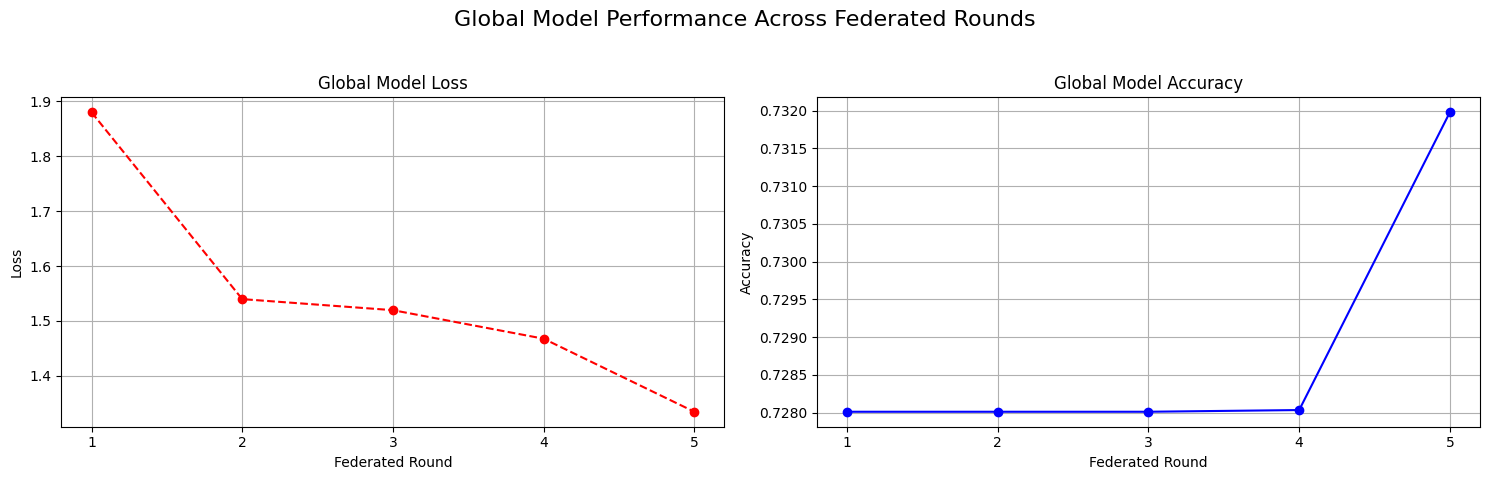

In [27]:
import matplotlib.pyplot as plt

# Create a figure with two subplots: one for loss, one for accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Global Model Performance Across Federated Rounds', fontsize=16)

# Plotting Global Model Loss
ax1.plot(range(1, len(history['loss']) + 1), history['loss'], marker='o', color='r', linestyle='--')
ax1.set_title('Global Model Loss')
ax1.set_xlabel('Federated Round')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.set_xticks(range(1, len(history['loss']) + 1)) # Ensure integer ticks for rounds

# Plotting Global Model Accuracy
ax2.plot(range(1, len(history['accuracy']) + 1), history['accuracy'], marker='o', color='b', linestyle='-')
ax2.set_title('Global Model Accuracy')
ax2.set_xlabel('Federated Round')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.set_xticks(range(1, len(history['accuracy']) + 1)) # Ensure integer ticks for rounds


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

1387/1387 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
--- Classification Report (Batch Model) ---
              precision    recall  f1-score   support

     Class 0       0.73      1.00      0.84     32299
     Class 1       0.99      0.01      0.03     12067

    accuracy                           0.73     44366
   macro avg       0.86      0.51      0.44     44366
weighted avg       0.80      0.73      0.62     44366


--- Confusion Matrix (Batch Model) ---


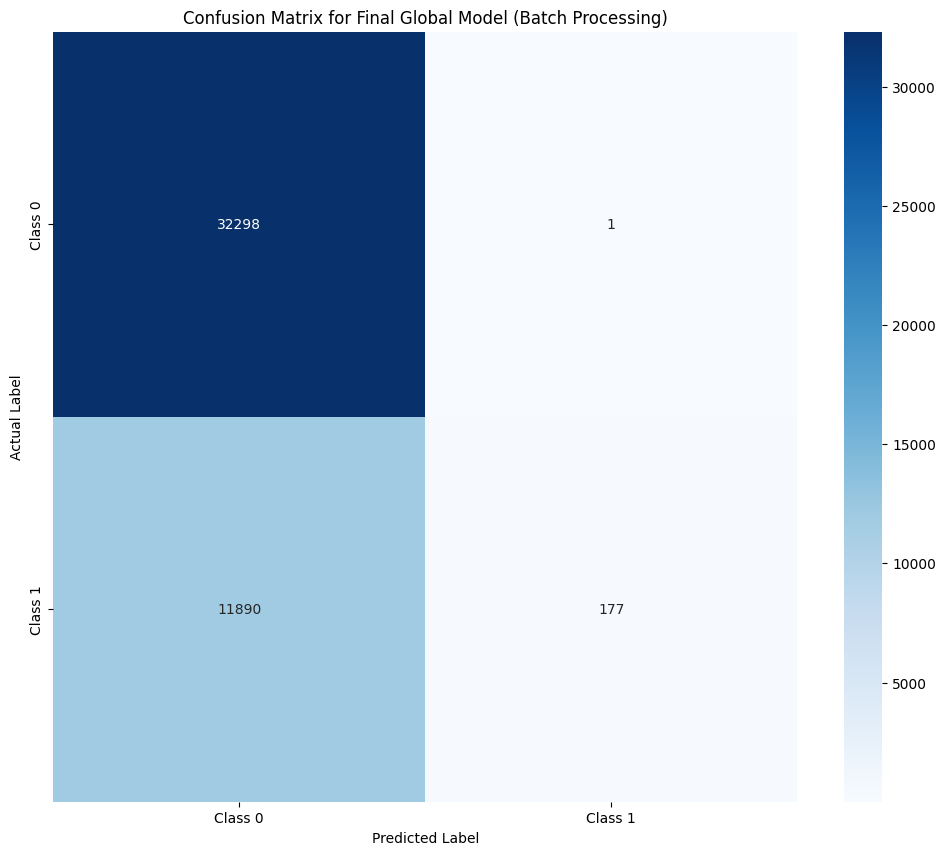

In [28]:
# Final Evaluation of the Batch Processing Model

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generate Predictions on the Test Set
# Use the final global model to predict probabilities on the test data
y_pred_probs = global_model.predict(X_test_seq)

# Convert probabilities to class labels
if NUM_CLASSES == 2:
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()
else:
    y_pred = np.argmax(y_pred_probs, axis=1)

# Ensure y_test_seq is in the correct format (1D array)
y_test_true = y_test_seq.flatten()


# Classification Report
print("--- Classification Report (Batch Model) ---")

# Correctly use the `encoder` variable to get class names
try:
    # This will now correctly find the `encoder` object created during data prep
    class_names = list(encoder.classes_)
except NameError:
    # Fallback for binary mode or if encoder isn't defined
    class_names = [f'Class {i}' for i in range(NUM_CLASSES)]

# Use zero_division=0 to prevent warnings on classes with no predictions
print(classification_report(y_test_true, y_pred, target_names=class_names, zero_division=0))


# Confusion Matrix
print("\n--- Confusion Matrix (Batch Model) ---")
cm = confusion_matrix(y_test_true, y_pred)

# For better visualization with many classes, increase the figure size
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Final Global Model (Batch Processing)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

---
### **Part 2: Federated Stream Processing Simulation**

After the baseline from the batch processing simulation, next is a a more realistic stream processing scenario. We will break each client's data into smaller chunks and train the global model incrementally, round by round.

In [29]:
# Simulating Federated Stream Processing

# New Parameters for Stream Simulation
STREAM_CHUNK_SIZE = 512 # How many data points are in each "stream chunk"

# This dictionary will hold the partitioned data streams for each client
federated_data_streams = {}

# We'll use the existing 'federated_train_data' to create the streams
for client_id, (client_X, client_y) in federated_train_data.items():
    chunks_X = []
    chunks_y = []
    for i in range(0, len(client_X), STREAM_CHUNK_SIZE):
        chunks_X.append(client_X[i:i + STREAM_CHUNK_SIZE])
        chunks_y.append(client_y[i:i + STREAM_CHUNK_SIZE])

    federated_data_streams[client_id] = {'X': chunks_X, 'y': chunks_y}
    print(f"Created {len(chunks_X)} data stream chunks for {client_id}.")

# The number of rounds is now limited by the client with the fewest chunks
ROUNDS_STREAM = min(len(client_stream['X']) for client_stream in federated_data_streams.values())
print(f"\n➡️ Stream simulation will run for {ROUNDS_STREAM} rounds based on the shortest client stream.")

Created 22 data stream chunks for client_1.
Created 22 data stream chunks for client_2.
Created 22 data stream chunks for client_3.
Created 22 data stream chunks for client_4.

➡️ Stream simulation will run for 22 rounds based on the shortest client stream.


In [30]:
# The Federated Stream Processing Loop

# Create new variables to avoid overwriting the batch results
global_model_stream = create_lstm_model(INPUT_SHAPE, NUM_CLASSES)
history_stream = {'loss': [], 'accuracy': []}

print("\n🚀 Starting Federated STREAMING Simulation...")

# This is the main federated STREAMING loop
for r in range(ROUNDS_STREAM):
    print(f"\n--- Stream Round {r+1}/{ROUNDS_STREAM} ---")
    local_model_weights = []

    for client_id in federated_data_streams.keys():
        local_model = create_lstm_model(INPUT_SHAPE, NUM_CLASSES)
        local_model.set_weights(global_model_stream.get_weights())

        stream_chunk_X = federated_data_streams[client_id]['X'][r]
        stream_chunk_y = federated_data_streams[client_id]['y'][r]

        print(f"  Training {client_id} on its data chunk for round {r+1} (size={len(stream_chunk_X)})...")
        local_model.fit(stream_chunk_X, stream_chunk_y,
                        epochs=LOCAL_EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=0)
        local_model_weights.append(local_model.get_weights())

    # GLOBAL AGGREGATION
    new_global_weights = []
    num_layers = len(global_model_stream.get_weights())
    for i in range(num_layers):
        layer_weights = np.array([client_weights[i] for client_weights in local_model_weights], dtype=object)
        avg_layer_weights = np.mean(layer_weights, axis=0)
        new_global_weights.append(avg_layer_weights)
    global_model_stream.set_weights(new_global_weights)

    # GLOBAL EVALUATION
    loss, acc = global_model_stream.evaluate(X_test_seq, y_test_seq, verbose=0)
    print(f"  GLOBAL MODEL (Stream) EVALUATION: Loss={loss:.4f}, Accuracy={acc:.4f}")
    history_stream['loss'].append(loss)
    history_stream['accuracy'].append(acc)

print("\n✅ Federated stream simulation complete.")


🚀 Starting Federated STREAMING Simulation...

--- Stream Round 1/22 ---
  Training client_1 on its data chunk for round 1 (size=512)...
  Training client_2 on its data chunk for round 1 (size=512)...
  Training client_3 on its data chunk for round 1 (size=512)...
  Training client_4 on its data chunk for round 1 (size=512)...
  GLOBAL MODEL (Stream) EVALUATION: Loss=0.6484, Accuracy=0.6930

--- Stream Round 2/22 ---
  Training client_1 on its data chunk for round 2 (size=512)...
  Training client_2 on its data chunk for round 2 (size=512)...
  Training client_3 on its data chunk for round 2 (size=512)...
  Training client_4 on its data chunk for round 2 (size=512)...
  GLOBAL MODEL (Stream) EVALUATION: Loss=0.5996, Accuracy=0.7223

--- Stream Round 3/22 ---
  Training client_1 on its data chunk for round 3 (size=512)...
  Training client_2 on its data chunk for round 3 (size=512)...
  Training client_3 on its data chunk for round 3 (size=512)...
  Training client_4 on its data chunk f


##################################################
📊 Final Detailed Report for: STREAM PROCESSING MODEL
##################################################
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

--- Classification Report (Stream Model) ---
              precision    recall  f1-score   support

     Class 0       0.73      1.00      0.84     32299
     Class 1       0.00      0.00      0.00     12067

    accuracy                           0.73     44366
   macro avg       0.36      0.50      0.42     44366
weighted avg       0.53      0.73      0.61     44366


--- Confusion Matrix (Stream Model) ---


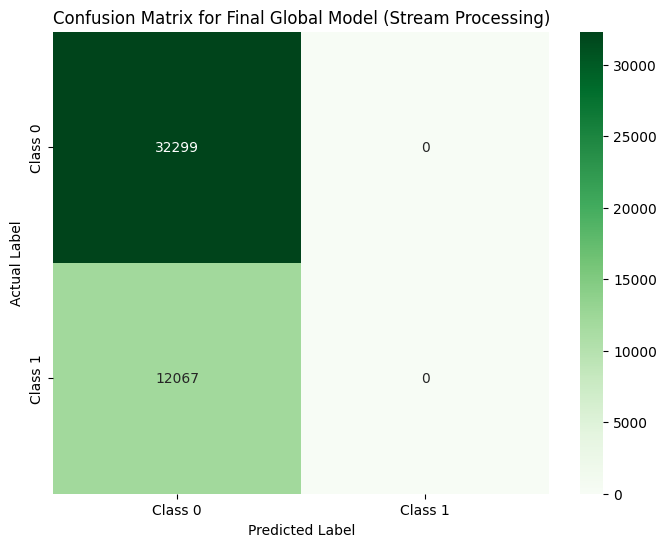

In [31]:
# Final Evaluation of the Stream Processing Model

print("\n" + "#"*50)
print("📊 Final Detailed Report for: STREAM PROCESSING MODEL")
print("#"*50)

# Use the final model from the stream simulation (`global_model_stream`)
y_pred_probs_stream = global_model_stream.predict(X_test_seq)

# Determine the prediction format based on the number of classes
if NUM_CLASSES == 2:
    y_pred_stream = (y_pred_probs_stream > 0.5).astype(int).flatten()
    # For binary, we can define class names manually for clarity
    class_names_stream = ['Class 0', 'Class 1']
else:
    y_pred_stream = np.argmax(y_pred_probs_stream, axis=1)
    # For multi-class, try to get the names from the encoder if it exists
    try:
        class_names_stream = list(encoder.classes_)
    except NameError:
        class_names_stream = [f'Class {i}' for i in range(NUM_CLASSES)]


# The true labels remain the same (y_test_seq)
y_test_true = y_test_seq.flatten()

# Print the Classification Report
print("\n--- Classification Report (Stream Model) ---")
print(classification_report(y_test_true, y_pred_stream, target_names=class_names_stream, zero_division=0))

#  Display the Confusion Matrix
print("\n--- Confusion Matrix (Stream Model) ---")
cm_stream = confusion_matrix(y_test_true, y_pred_stream)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_stream, annot=True, fmt='d', cmap='Greens', xticklabels=class_names_stream, yticklabels=class_names_stream)
plt.title('Confusion Matrix for Final Global Model (Stream Processing)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

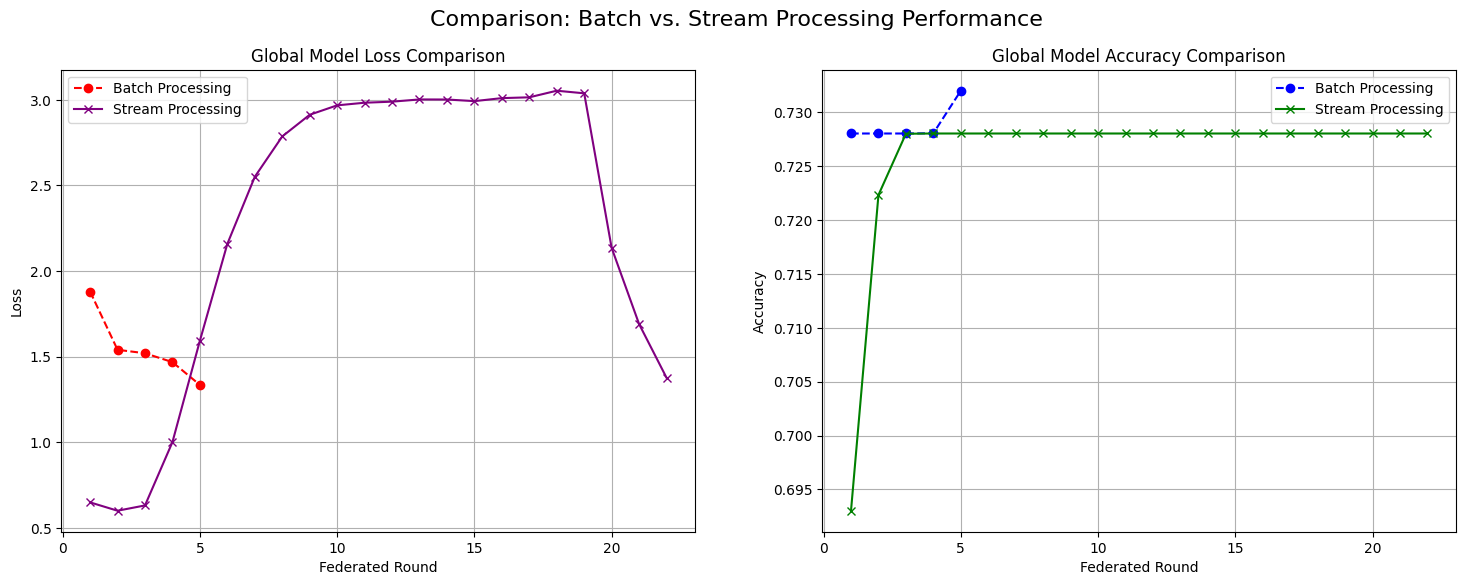

In [32]:
# === 15. Visualize and Compare: Batch vs. Stream ===

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Comparison: Batch vs. Stream Processing Performance', fontsize=16)

# Plotting Loss
ax1.plot(range(1, len(history['loss']) + 1), history['loss'], marker='o', color='r', linestyle='--', label='Batch Processing')
ax1.plot(range(1, len(history_stream['loss']) + 1), history_stream['loss'], marker='x', color='purple', linestyle='-', label='Stream Processing')
ax1.set_title('Global Model Loss Comparison')
ax1.set_xlabel('Federated Round')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

# Plotting Accuracy
ax2.plot(range(1, len(history['accuracy']) + 1), history['accuracy'], marker='o', color='b', linestyle='--', label='Batch Processing')
ax2.plot(range(1, len(history_stream['accuracy']) + 1), history_stream['accuracy'], marker='x', color='green', linestyle='-', label='Stream Processing')
ax2.set_title('Global Model Accuracy Comparison')
ax2.set_xlabel('Federated Round')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.legend()

plt.show()